## Digit Detector


In [1]:
using Images
using Plots
using FileIO
using Revise
using BSON
using Flux

In [2]:
Revise.includet("../utilities/Transforms.jl")
using .Transforms

Revise.includet("../GridDetection/GridDetection.jl")
using .GridDetection

Revise.includet("../DigitDetection/DigitExtraction.jl")
using .DigitExtration

┌ Warning: Replacing docs for `Main.DigitExtration.calc_connected_component_statistics :: Tuple{AbstractArray, Int64}` in module `Main.DigitExtration`
└ @ Base.Docs docs\Docs.jl:240


## Load image

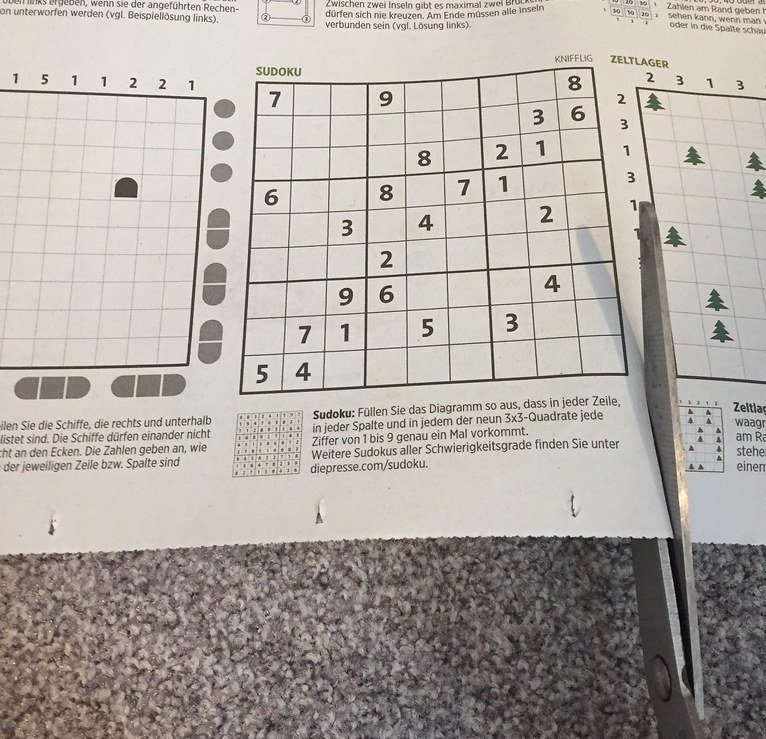

In [3]:
image_path = "../images/sudoku_thinkfun.jpg";
image_raw = load(image_path)
image = copy(image_raw)

## Get grid

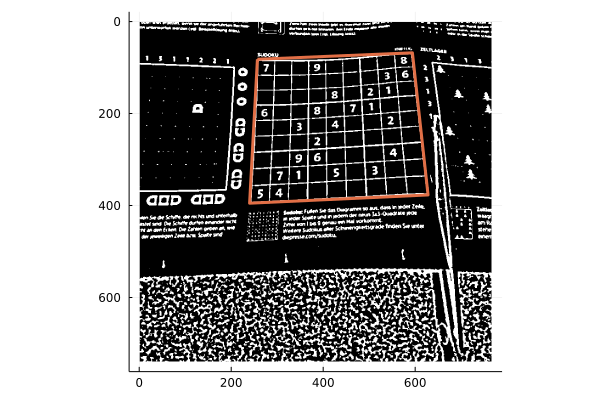

In [4]:
blackwhite, quad = detect_grid(image);
canvas = plot(blackwhite)

x = [point[2] for point in vcat(quad, quad[1])]
y = [point[1] for point in vcat(quad, quad[1])]
plot!(canvas, x, y, linewidth=3, label="")

## Extract digits

  1.625726 seconds (3.25 M allocations: 197.644 MiB, 3.03% gc time, 92.03% compilation time)


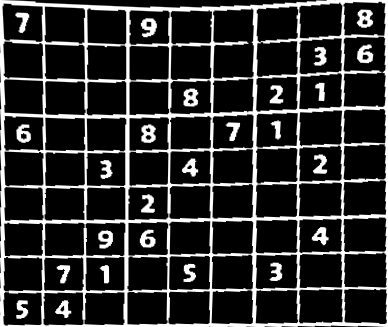

In [5]:
@time warped, invM = four_point_transform(blackwhite, quad)
warped

In [6]:
BSON.@load "..\\DigitDetection\\models\\LeNet5_both_e20.bson" model
model(zeros(Float32, (28, 28, 1, 1))) # compile
model

Chain(
  Conv((5, 5), 1 => 6, relu),           # 156 parameters
  MaxPool((2, 2)),
  Conv((5, 5), 6 => 16, relu),          # 2_416 parameters
  MaxPool((2, 2)),
  Flux.flatten,
  Dense(256, 120, relu),                # 30_840 parameters
  Dense(120, 84, relu),                 # 10_164 parameters
  Dense(84, 10),                        # 850 parameters
)                   # Total: 10 arrays, 44_426 parameters, 174.867 KiB.

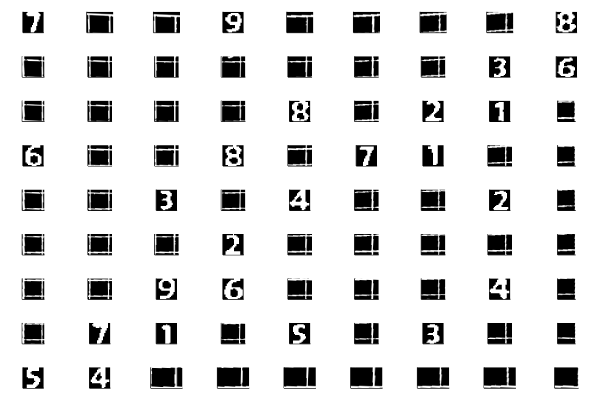

9×9 Matrix{Int64}:
 7  0  0  9  0  0  0  0  8
 0  0  0  0  0  0  0  3  6
 0  0  0  0  8  0  2  1  0
 6  0  0  8  0  7  1  0  0
 0  0  3  0  4  0  0  2  0
 0  0  0  2  0  0  0  0  0
 0  0  9  6  0  0  0  4  0
 0  7  1  0  5  0  3  0  0
 5  4  0  0  0  0  0  0  0

9×9 Matrix{Float32}:
 1.0  0.0  0.0       1.0  0.0       0.0  0.0       0.0       1.0
 0.0  0.0  0.0       0.0  0.0       0.0  0.0       1.0       1.0
 0.0  0.0  0.0       0.0  1.0       0.0  1.0       0.999932  0.0
 1.0  0.0  0.0       1.0  0.0       1.0  0.999999  0.0       0.0
 0.0  0.0  1.0       0.0  1.0       0.0  0.0       0.999974  0.0
 0.0  0.0  0.0       1.0  0.0       0.0  0.0       0.0       0.0
 0.0  0.0  1.0       1.0  0.0       0.0  0.0       1.0       0.0
 0.0  1.0  0.992123  0.0  0.999995  0.0  1.0       0.0       0.0
 1.0  1.0  0.0       0.0  0.0       0.0  0.0       0.0       0.0

25 regions need to be examined


In [7]:
height, width = size(warped)
step_i = Int(ceil(height / 9))
step_j = Int(ceil(width / 9))
Δoffset = 0.1
offset_i = Int(round(Δoffset * step_i))
offset_j = Int(round(Δoffset * step_j))
canvases = []
num_detections = 0

grid = zeros(Int, (9, 9))
centres =  [(-1.0, -1.0) for i in 1:9, j in 1:9]
probs = zeros(Float32, (9, 9))

for (i_grid, i_img) in enumerate(1:step_i:height)
    for (j_grid, j_img) in enumerate(1:step_j:width)
        prev_i = max(1, i_img - offset_i)
        prev_j = max(1, j_img - offset_j)
        next_i = min(i_img + step_i + offset_i, height)
        next_j = min(j_img + step_j + offset_j, width)
        RoI = warped[prev_i:next_i, prev_j:next_j]
        if detect_in_centre(RoI)
            num_detections += 1
            centre, digit = extract_digit(RoI, threshold=0.1)
            ŷ, prob = prediction(model, digit)
            grid[i_grid, j_grid] = ŷ
            canvas = plot(Gray.(digit))
            
            centre = (centre[1] + prev_i, centre[2] + prev_j)
            probs[i_grid, j_grid] = prob
        else
            centre =(prev_i + step_i/2, prev_j + step_j/2)
            canvas = plot(RoI)
        end
        centres[i_grid, j_grid] = centre
        push!(canvases, canvas)
    end
end
println("$num_detections regions need to be examined")
extracted = plot(canvases..., layout=(9, 9), ticks=nothing, border=nothing)
display(extracted)
display(grid)
display(probs)

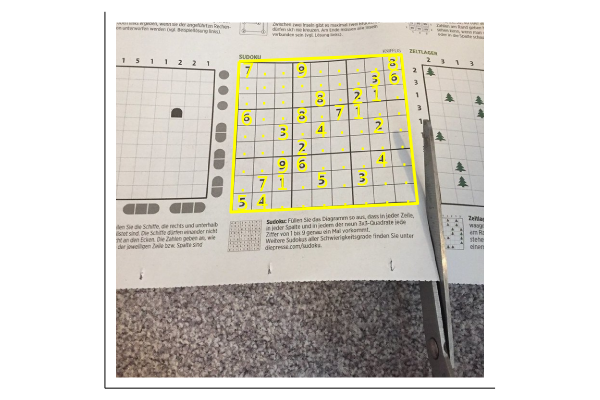

In [8]:
threshold = 0.9
image_out = imresize(image, size(blackwhite));
canvas = plot(image_out, ticks=nothing, border=nothing);
plot!(canvas, 
    [point[2] for point in vcat(quad, quad[1])], 
    [point[1] for point in vcat(quad, quad[1])], 
    linewidth=3, label="", color=:yellow
);

for i in 1:9
    for j in 1:9
        centre = centres[i, j]
        centre_unwarped = perspective_transform(invM)(centre)
        label =  (probs[i, j] > threshold) ? string(grid[i, j]) : "."
        annotate!(canvas, centre_unwarped[2], centre_unwarped[1], label, :yellow)
    end
end
canvas

## Single digit test

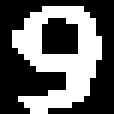

In [12]:
height, width = size(warped)
step_i = Int(ceil(height / 9))
step_j = Int(ceil(width / 9))


Δoffset = 0.1
offset_i = Int(round(Δoffset * step_i))
offset_j = Int(round(Δoffset * step_j))

i, j = 0* step_i, 3* step_j
prev_i = max(1, i - offset_i)
prev_j = max(1, j - offset_j)
next_i = min(i + step_i + offset_i, height)
next_j = min(j + step_j + offset_j, width)
RoI = warped[prev_i:next_i, prev_j:next_j]
detect_in_centre(RoI)
centre, digit = extract_digit(RoI, threshold=0.1)
digit

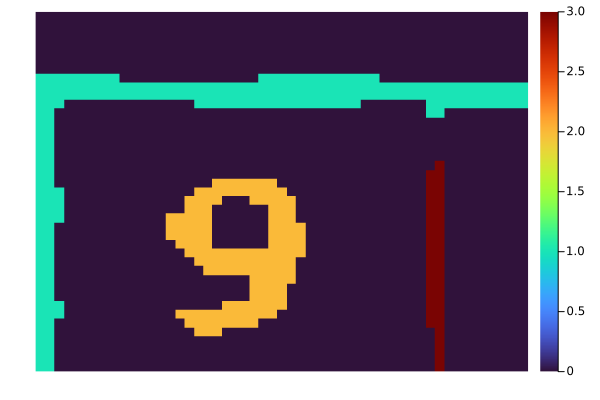

In [13]:
RoI[RoI .< 0.9 ] .= 0
RoI[RoI .> 0.9 ] .= 1
labels = label_components(RoI)
heatmap(labels, yflip=true, c=:turbo, border=:none)

In [17]:
h = size(RoI, 1)
w = size(RoI, 2)
r =  min(h, w) * 0.25
kernel = make_circle_kernel(h, w, r)
Gray.(kernel .* RoI) 
sum(kernel .* RoI .!= 0)/(pi * r * r)


0.2635855809445786

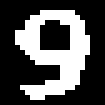

In [15]:
height, width = size(digit)
pad = floor(Int, 0.1 * max(height, width))
imnew = zeros(Float32, (height + 2pad, width +2pad))
imnew[(pad + 1):(pad + height), (pad + 1):(pad + width)] = digit
Gray.(imnew)

In [16]:
digit_ = imresize(digit, (28, 28))
x = Flux.batch([Flux.unsqueeze(Float32.(digit_), 3)])
logits = model(x)
probabilites = softmax(logits)
idx = argmax(probabilites)
ŷ = idx[1] - 1
ŷ, probabilites[idx]

(9, 1.0f0)